# Pythia

**Reference: Building an image search service from scratch**  https://github.com/hundredblocks/semantic-search

In this notebook I

* use Keras' MobileNet and its ImageNet pretrained weights to generate embeddings for the frames of the videos.
* index the extracted features for fast search.
* search for frames similar to the given input frame. 
    * **Note**. For now, I will only do the search through the frames belonging to a single video
* Reconstruct parts of the videos containing the resulting frames.

In [2]:
import time 
import os
import matplotlib.pyplot as plt 
import io
import base64
from IPython.display import HTML
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import vector_search
%matplotlib inline

generate_image_features = True
image_paths = ["../data/train/frames/Greek_Layered_Dip_Recipe/frame{}.png".format(i)
               for i in range(len(os.listdir('../data/train/frames/Greek_Layered_Dip_Recipe')))]
features_path = '../data/train/features'
file_mapping_path = '../data/train/mapping_filename'

## Generate Features and Map Them to Images

In [3]:
start_time = time.time()
model = vector_search.load_headless_pretrained_model()
if generate_image_features:
    t_1 = time.time()
    images_features, file_index = vector_search.generate_features(image_paths, model)
    t_2 = time.time()
    print("Finished generating features ...... {} seconds".format(t_2-t_1))
    t_1 = time.time()
    vector_search.save_features(features_path, images_features, file_mapping_path, file_index)
    t_2 = time.time()
    print('Finished saving features ...........{} seconds'.format(t_2-t_1))
else:
    images_features, index_path_mapping = vector_search.load_features(features_path, file_mapping_path)
end_time = time.time()
print('Done! ....... {} seconds'.format(end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

## Index Features for fast search

Now that we have the features, we will build a fast index to search through them using Annoy

In [4]:
start_time = time.time()
image_index = vector_search.index_features(images_features)
end_time = time.time()
print("Done! ...... {} seconds".format(round(end_time - start_time, 2)))

Indexing features...
Done! ...... 0.13 seconds


## Search through frames using the embeddings

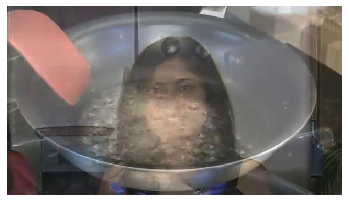

In [82]:
search_key = 10   # this corresponds to the image plotted below

img = plt.imread('../data/train/frames/Greek_Layered_Dip_Recipe/frame{}.png'.format(search_key))   # reading image using its name
_ = plt.axis('off')
_ = plt.imshow(img)

In [83]:
start_time = time.time()
print("Searching for similar frames......")
results = vector_search.search_index_by_key(search_key, image_index, file_index, top_n=12)
print("Done searching ........... {} seconds".format(round(time.time() - start_time, 2)))
#results

Searching for similar frames......
Done searching ........... 0.0 seconds


## Plot similar frames found by the search

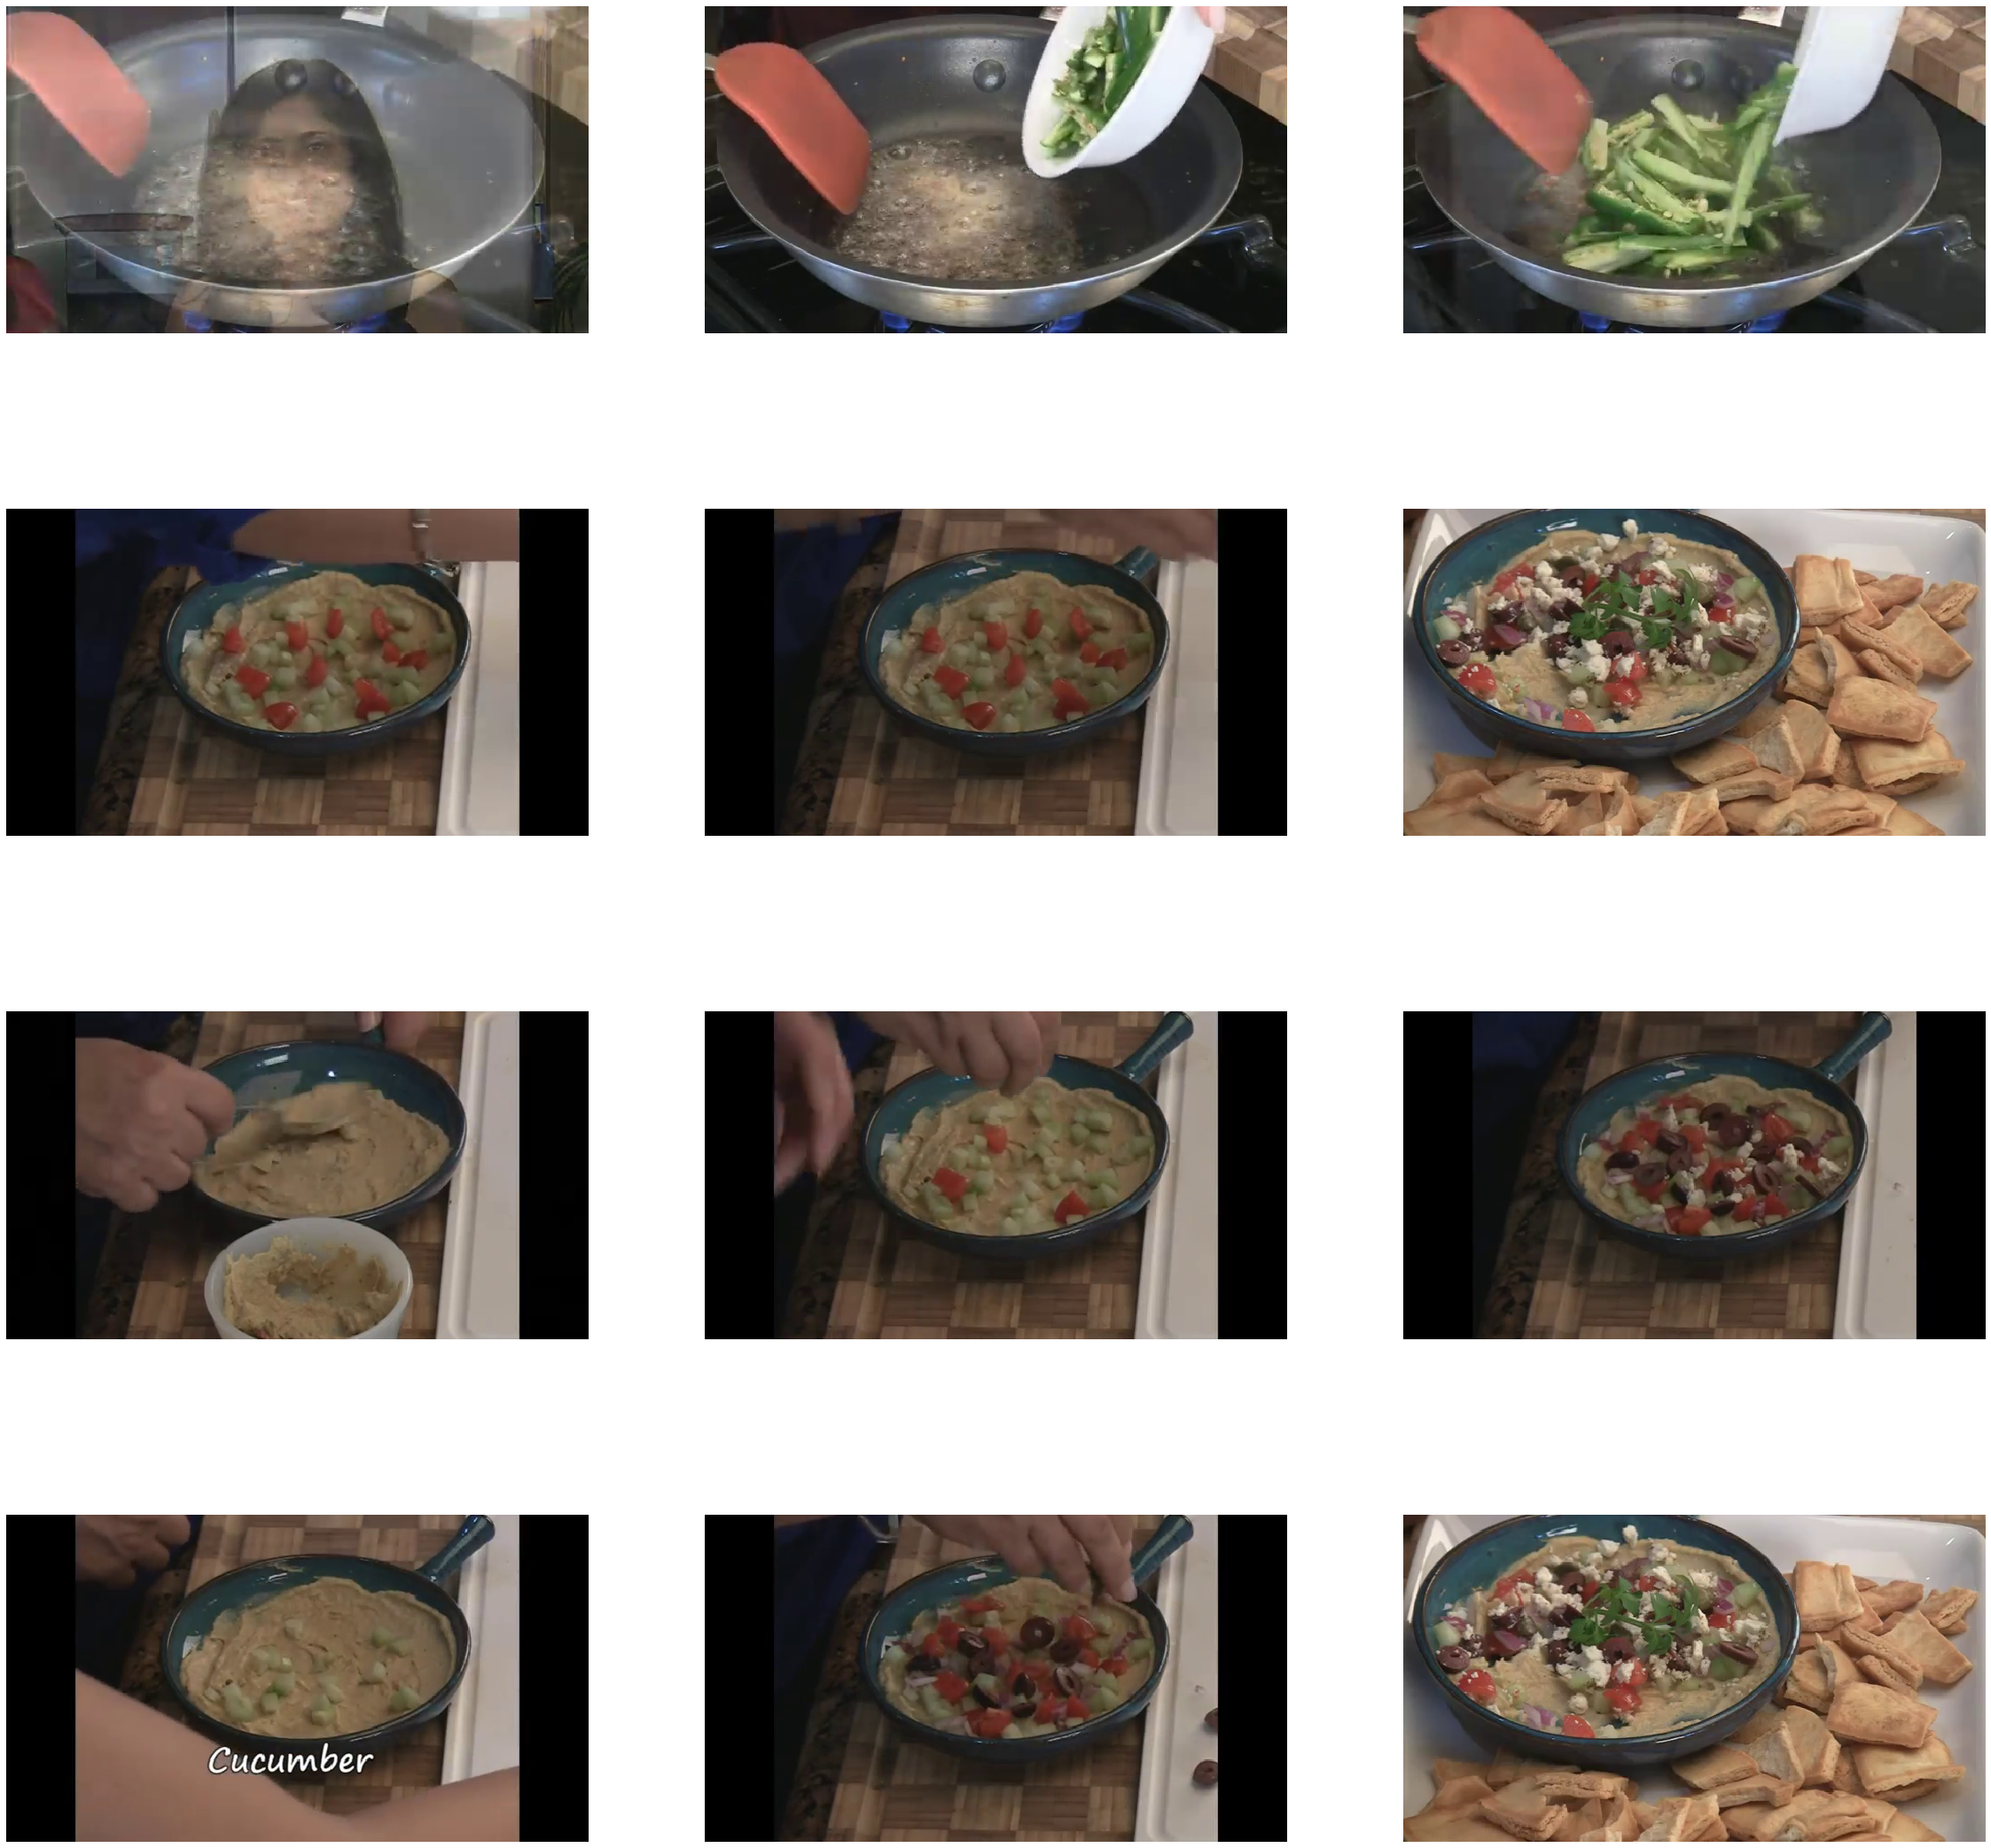

In [84]:
fig=plt.figure(figsize=(40, 40))
for i in range(1, 12 + 1):
    img = plt.imread('../data/train/frames/Greek_Layered_Dip_Recipe/frame{}.png'.format(results[i-1][0]))   
    fig.add_subplot(4, 3, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Reconstruct videos from frames and save into .mp4 files

In [85]:
for i, h in enumerate(results):
    print(i, '-------', h)

0 ------- [10, '../data/train/frames/Greek_Layered_Dip_Recipe/frame10.png', 0.0]
1 ------- [11, '../data/train/frames/Greek_Layered_Dip_Recipe/frame11.png', 0.8276546597480774]
2 ------- [12, '../data/train/frames/Greek_Layered_Dip_Recipe/frame12.png', 0.851982593536377]
3 ------- [108, '../data/train/frames/Greek_Layered_Dip_Recipe/frame108.png', 1.0130633115768433]
4 ------- [107, '../data/train/frames/Greek_Layered_Dip_Recipe/frame107.png', 1.064217448234558]
5 ------- [230, '../data/train/frames/Greek_Layered_Dip_Recipe/frame230.png', 1.0732624530792236]
6 ------- [75, '../data/train/frames/Greek_Layered_Dip_Recipe/frame75.png', 1.0739750862121582]
7 ------- [102, '../data/train/frames/Greek_Layered_Dip_Recipe/frame102.png', 1.075086236000061]
8 ------- [154, '../data/train/frames/Greek_Layered_Dip_Recipe/frame154.png', 1.0751235485076904]
9 ------- [83, '../data/train/frames/Greek_Layered_Dip_Recipe/frame83.png', 1.0773159265518188]
10 ------- [128, '../data/train/frames/Greek_Lay

In [86]:
results.sort(key=lambda x:x[0])
for i, h in enumerate(results):
    print(i, "...", h)

0 ... [10, '../data/train/frames/Greek_Layered_Dip_Recipe/frame10.png', 0.0]
1 ... [11, '../data/train/frames/Greek_Layered_Dip_Recipe/frame11.png', 0.8276546597480774]
2 ... [12, '../data/train/frames/Greek_Layered_Dip_Recipe/frame12.png', 0.851982593536377]
3 ... [75, '../data/train/frames/Greek_Layered_Dip_Recipe/frame75.png', 1.0739750862121582]
4 ... [83, '../data/train/frames/Greek_Layered_Dip_Recipe/frame83.png', 1.0773159265518188]
5 ... [102, '../data/train/frames/Greek_Layered_Dip_Recipe/frame102.png', 1.075086236000061]
6 ... [107, '../data/train/frames/Greek_Layered_Dip_Recipe/frame107.png', 1.064217448234558]
7 ... [108, '../data/train/frames/Greek_Layered_Dip_Recipe/frame108.png', 1.0130633115768433]
8 ... [128, '../data/train/frames/Greek_Layered_Dip_Recipe/frame128.png', 1.0796059370040894]
9 ... [154, '../data/train/frames/Greek_Layered_Dip_Recipe/frame154.png', 1.0751235485076904]
10 ... [228, '../data/train/frames/Greek_Layered_Dip_Recipe/frame228.png', 1.08144092559

* Group the resulting frames so that every group contains only consecutive indices 
* For every group, go to the corresponding video and cut the video based on the indices of the frames

In [87]:
current_index = results[0][0]
indices = []
count = 0
for i, list_item in enumerate(results):
    if (len(indices) == 0):
        indices.append([list_item[0]])
        continue
    elif list_item[0] != current_index + 1:
        indices.append([list_item[0]])
        count += 1
    else:
        indices[count].append(list_item[0])
    current_index = results[i][0]
print(indices)

[[10, 11, 12], [75], [83], [102], [107, 108], [128], [154], [228], [230]]


In [89]:
t = time.time()
video_path = '../data/train/videos/Greek_Layered_Dip_Recipe.mp4'
count = 0

for i, item in enumerate(indices):
    target_name = '../data/results/subvideo_{}.mp4'.format(count)
    start_time = item[0]
    end_time = item[-1]
    if end_time-start_time > 1:
        ffmpeg_extract_subclip(video_path, start_time, end_time, targetname=target_name)
        count += 1
    else:
        continue
print("Done ......... {} seconds".format(time.time() - t))


[MoviePy] Running:
>>> /Users/araks/anaconda3/envs/tensorflow_env/bin/ffmpeg -y -i ../data/train/videos/Greek_Layered_Dip_Recipe.mp4 -ss 10.00 -t 2.00 -vcodec copy -acodec copy ../data/results/subvideo_0.mp4
... command successful.
Done ......... 0.14320015907287598 seconds


In [91]:
video = io.open('../data/results/subvideo_0.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))